In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm

In [2]:
dof='__pb_dof'
mc_file = f"workspace/comp_sep/cmb_r0p00__dust_prior_beta_alpha__noise{dof}/data/mcmc.hdf5"
sim_mc_filebase = "workspace/comp_sep/cmb_r0p00__dust_prior_beta_alpha__noise__gm_dof"

In [3]:
mc_dat = h5py.File(mc_file,'r')
chi = mc_dat['chi2_eff'].value

/global/homes/l/lonappan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [4]:
with h5py.File(mc_file, 'r') as f:
    chains_d = f['chain'][...]
    chi2_eff_d = f['chi2_eff'][...]
    logL_d = f['logL'][...]
    dl_data_d = f['dl_data'][...]
    dl_best_fit_d = f['dl_best_fit'][...]
    best_fit_d = f['best_fit'][...]
    dof_d = f['dof'][...]

def get_chi2_1d(best_fit, data):
    dl_diag = np.einsum('iil->il', best_fit)
    sigma = np.sqrt((dl_diag * dl_diag[:, None] + best_fit**2) / dof_d)
    upper_triangle = np.arange(4) >= np.arange(4)[:, None]
    chi2_1d = ((data - best_fit) / sigma)[upper_triangle]
    return chi2_1d.flatten()

chi2_1d_data = get_chi2_1d(dl_best_fit_d, dl_data_d)

In [5]:
def poisson_interval(icounts):
        icounts = int(icounts)
        fcounts = float(icounts)

        if icounts > 20:
                _min = fcounts - np.sqrt(fcounts)
                _max = fcounts + np.sqrt(fcounts)
        elif icounts==20: _min=15.83; _max=25.30;
        elif icounts==19: _min=14.82; _max=23.82;
        elif icounts==18: _min=13.81; _max=22.82;
        elif icounts==17: _min=12.79; _max=21.81;
        elif icounts==16: _min=12.33; _max=20.80;
        elif icounts==15: _min=11.32; _max=19.32;
        elif icounts==14: _min=10.30; _max=18.32;
        elif icounts==13: _min=9.28; _max=17.30;
        elif icounts==12: _min=8.83; _max=16.29;
        elif icounts==11: _min=7.81; _max=14.82;
        elif icounts==10: _min=6.78; _max=13.31;
        elif icounts==9:  _min=6.33; _max=12.79;
        elif icounts==8:  _min=5.30; _max=11.32;
        elif icounts==7:  _min=4.25; _max=10.30;
        elif icounts==6:  _min=3.82; _max=9.28;
        elif icounts==5:  _min=2.75; _max=7.81;
        elif icounts==4:  _min=2.34; _max=6.78;
        elif icounts==3:  _min=1.10; _max=5.30;
        elif icounts==2:  _min=0.74; _max=4.25;
        elif icounts==1:  _min=0.37; _max=2.75;
        else: return 0., 0.

        return (fcounts - _min), (_max - fcounts)

In [6]:
chi2_eff = []
chains = []
logL = []
dl_best_fit = []
dl_data = []
for i in range(96):
    with h5py.File(f"{sim_mc_filebase}/sim{i:03}/mcmc.hdf5", 'r') as f:
        chains.append(f['chain'][...])
        chi2_eff.append(f['chi2_eff'][...])
        logL.append(f['logL'][...])
        dl_best_fit.append(f['dl_best_fit'][...])
        dl_data.append(f['dl_data'][...])

chi2_1d_sims = np.concatenate(
    [get_chi2_1d(best_fit, data)
     for best_fit, data in zip(dl_best_fit, dl_data)])

/global/homes/l/lonappan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/global/homes/l/lonappan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """
/global/homes/l/lonappan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarnin

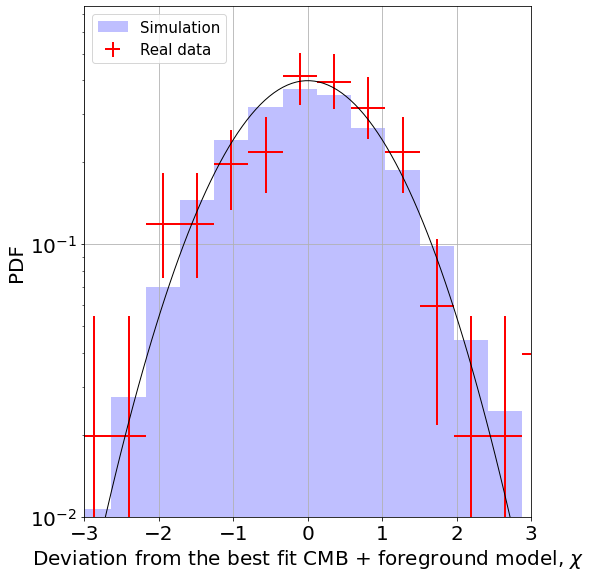

In [7]:
plt.figure(figsize=(8,8))
_, bins = np.histogram(chi2_1d_sims, normed=True, bins=20)
plt.hist(chi2_1d_sims, density=True, bins=bins, color='b', lw=0,
            alpha=0.25, label='Simulation')
hist_chi2, _ = np.histogram(chi2_1d_data, normed=True, bins=bins)
unnormed_hist = np.histogram(chi2_1d_data, bins=bins)[0]
bin_center = (bins[1:] + bins[:-1]) / 2.
yerr = [np.array(poisson_interval(u)) * h / u
        for u, h in zip(unnormed_hist, hist_chi2)]
yerr = np.array(yerr).T
xerr = (bins[1] - bins[0]) / 2.
plt.errorbar(bin_center, hist_chi2, yerr=yerr, xerr=xerr, c='r', ls='none',
        capsize=0, elinewidth=2, label='Real data')
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, None)
xs = np.linspace(-3, 3, 100)
plt.plot(xs, norm.pdf(xs), 'k', lw=1)
plt.xlabel('Deviation from the best fit CMB + foreground model, $\\chi$',fontsize='20')
plt.ylabel('PDF',fontsize='20')
plt.tight_layout()
plt.legend(numpoints=1, loc=2,fontsize='15')
plt.xlim(-3, 3)
plt.gca().grid(b=True)
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.savefig(f"plots/dev{dof}.png",bbox_inches='tight')